In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.stattools import adfuller
import statsmodels.api as sm
from sklearn.preprocessing import MinMaxScaler

import torch
import torch.nn as nn
import torch.nn.functional as F

In [2]:
data = pd.read_csv("data/final.csv")

data['YearMonth'] = pd.to_datetime(data['YearMonth'])
data.set_index('YearMonth', inplace=True)
data.head()

,Temperature
YearMonth,
1880-01-01,-0.36
1880-02-01,-0.51
1880-03-01,-0.23
1880-04-01,-0.30
1880-05-01,-0.06


# 1.Neural Network

In [3]:
tst_size = 20
tst_data  = data [-tst_size :]

In [4]:
data.head()

,Temperature
YearMonth,
1880-01-01,-0.36
1880-02-01,-0.51
1880-03-01,-0.23
1880-04-01,-0.30
1880-05-01,-0.06


In [5]:
class TimeSeriesDataset(torch.utils.data.Dataset):
  def __init__(self, ts:np.array, lookback_size:int, forecast_size:int):
    self.lookback_size = lookback_size
    self.forecast_size = forecast_size
    self.data = ts

  def __len__(self):
    return len(self.data) - self.lookback_size - self.forecast_size + 1

  def __getitem__(self, i):
    idx = (i+self.lookback_size)
    look_back = self.data[i:idx]
    forecast = self.data[idx:idx+self.forecast_size]

    return look_back, forecast

In [6]:
from sklearn.preprocessing import MinMaxScaler

# lookback_size = 9
lookback_size = 50
forecast_size = 4

scaler = MinMaxScaler()
trn_scaled = scaler.fit_transform(data[:-tst_size].to_numpy(dtype=np.float32)).flatten()
tst_scaled = scaler.transform(data[-tst_size-lookback_size:].to_numpy(dtype=np.float32)).flatten()

trn_ds = TimeSeriesDataset(trn_scaled, lookback_size, forecast_size)
tst_ds = TimeSeriesDataset(tst_scaled, lookback_size, forecast_size)

trn_dl = torch.utils.data.DataLoader(trn_ds, batch_size=32, shuffle=True)
tst_dl = torch.utils.data.DataLoader(tst_ds, batch_size=tst_size, shuffle=False)

In [7]:
x, y = next(iter(trn_dl))

x.shape, y.shape

(torch.Size([32, 50]), torch.Size([32, 4]))

In [8]:
class Net(nn.Module):
  # def __init__(self, d_in, d_out, d_hidden, activation=F.relu):
  def __init__(self, d_in, d_out, d_hidden, d_hidden2, activation=F.relu):
    super().__init__()
    self.lin1 = nn.Linear(d_in, d_hidden)
    self.lin2 = nn.Linear(d_hidden, d_hidden2)
    self.lin3 = nn.Linear(d_hidden2, d_out)
    self.activation = activation

  def forward(self, x):
    x = self.lin1(x)
    x = self.activation(x)
    x = self.lin2(x)
    x = self.activation(x)
    x = self.lin3(x)
    return F.sigmoid(x)

In [9]:
from tqdm.auto import trange

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# net = Net(9, 4, 512)
net = Net(50, 4, 256, 512)
net.to(device)

optim = torch.optim.AdamW(net.parameters(), lr=0.0001)

pbar = trange(2000)
for i in pbar:
  net.train()
  trn_loss = .0
  for x, y in trn_dl:
    x, y = x.to(device), y.to(device)
    p = net(x)
    optim.zero_grad()
    loss = F.mse_loss(p, y)
    loss.backward()
    optim.step()
    trn_loss += loss.item()*len(y)
  trn_loss = trn_loss/len(trn_ds)

  net.eval()
  with torch.inference_mode():
    x, y = next(iter(tst_dl))
    x, y = x.to(device), y.to(device)
    p = net(x)
    tst_loss = F.mse_loss(p,y)
    # tst_mape = mape(p,y)
    # tst_mae = mae(p,y)
  pbar.set_postfix({'loss':trn_loss, 'tst_loss':tst_loss.item()})#, 'tst_mape':tst_mape.item(), 'tst_mae':tst_mae.item()})

/home/estsoft/miniconda3/envs/MathAI/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


100%|██████████| 2000/2000 [02:31<00:00, 13.18it/s, loss=0.000369, tst_loss=0.00129] 


In [10]:
net.eval()
with torch.inference_mode():
  x, y = next(iter(tst_dl))
  x, y = x.to(device), y.to(device)
  p = net(x)

def mape(y_pred, y_true):
  return (np.abs(y_pred - y_true)/y_true).mean() * 100

def mae(y_pred, y_true):
  return np.abs(y_pred - y_true).mean()


def r2_score(y_pred, y_true):
    ss_tot = np.sum((y_true - np.mean(y_true))**2)
    ss_res = np.sum((y_true - y_pred)**2)
    r2 = 1 - (ss_res / ss_tot)
    return r2

y = scaler.inverse_transform(y.cpu())
p = scaler.inverse_transform(p.cpu())

y = np.concatenate([y[:,0], y[-1,1:]])
p = np.concatenate([p[:,0], p[-1,1:]])

In [11]:
res_dict = {}

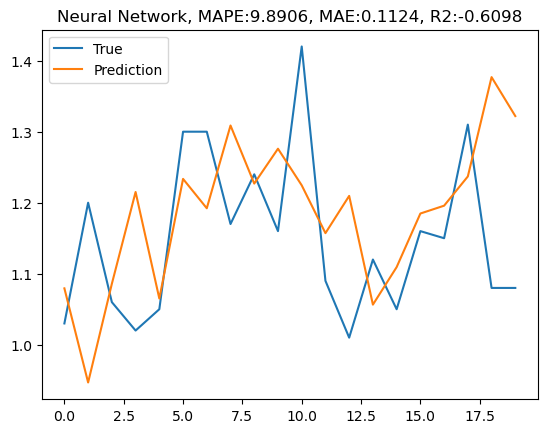

In [12]:
plt.title(f"Neural Network, MAPE:{mape(p,y):.4f}, MAE:{mae(p,y):.4f}, R2:{r2_score(p,y):.4f}")
plt.plot(range(tst_size), y, label="True")
plt.plot(range(tst_size), p, label="Prediction")
plt.legend()
plt.show()

res_dict.update({'NN(9,512,4)': {'MAPE':mape(p,y), 'MAE':mae(p,y)}})

In [13]:
torch.save(net.state_dict(), './model/AdamW_(50, 4, 256, 512, 2)model.pth')

(20, 4)
(20,)
MAPE:  18.046451005411047
MAE:  0.20158910012245176
R2_Score:  -4.143088642080485


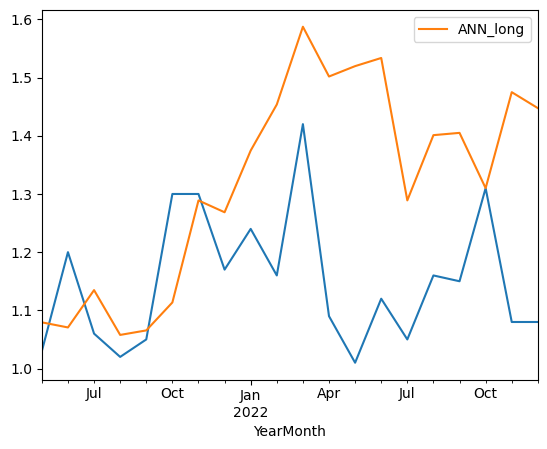

In [15]:
# 장기예측
# window_size = 9
window_size = 50
prediction_size = 4
test_size=20
preds = []

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
net.to(device)

# print(type(x), type(y))
x, y = trn_ds[len(trn_ds)-1]

for _ in range(test_size):
  #print(x.shape, y.shape)
  y=y.squeeze()
  #print(x.shape, y.shape)

  x = np.concatenate([x,y])[-window_size:]
  #x = x.flatten()
  #y = y.flatten()
    
  x_tensor = torch.tensor(x, dtype=torch.float32).to(device)
  #y = net(torch.tensor(x, dtype=torch.float32).to(device)) # your model
  y=net(x_tensor)
  y = y.detach().cpu().numpy()
  y= y.reshape(1,prediction_size)
  #print(x,y)
  preds.append(y)

preds = np.concatenate(preds, axis=0)
preds = scaler.inverse_transform(preds).squeeze()
print(preds.shape)
preds = preds[:,0]
print(preds.shape)


# 장기예측 plot
df = pd.DataFrame({"ANN_long": preds}, index=tst_data.index)
trn, tst = data.Temperature[:-20], data.Temperature[-20:]
ax = tst.plot(label="TRUE")
df.plot(ax=ax)

mape2 = mape(preds,data.Temperature[-tst_size:].to_numpy())
print("MAPE: ",mape2)
mae2 = mae(preds,data.Temperature[-tst_size:].to_numpy())
print("MAE: ",mae2)
r2_score2 = r2_score(preds,data.Temperature[-tst_size:].to_numpy())
print("R2_Score: ", r2_score2)

# 2.Multi-channel

In [16]:
m_data = data.copy()
m_data['rolling_mean'] = data.rolling(12).mean()
m_data

,Temperature,rolling_mean
YearMonth,,
1880-01-01,-0.36,NaN
1880-02-01,-0.51,NaN
1880-03-01,-0.23,NaN
1880-04-01,-0.30,NaN
1880-05-01,-0.06,NaN
...,...,...
2022-08-01,1.16,1.172500
2022-09-01,1.15,1.180833
2022-10-01,1.31,1.181667


In [17]:
m_data = m_data.dropna()

# lookback_size = 9
lookback_size = 50
forecast_size = 4

scaler = MinMaxScaler()
trn_scaled = scaler.fit_transform(m_data[:-tst_size].to_numpy(dtype=np.float32))
tst_scaled = scaler.transform(m_data[-tst_size-lookback_size:].to_numpy(dtype=np.float32))

trn_ds = TimeSeriesDataset(trn_scaled, lookback_size, forecast_size)
tst_ds = TimeSeriesDataset(tst_scaled, lookback_size, forecast_size)

trn_dl = torch.utils.data.DataLoader(trn_ds, batch_size=32, shuffle=True)
tst_dl = torch.utils.data.DataLoader(tst_ds, batch_size=tst_size, shuffle=False)

In [18]:
x, y = next(iter(trn_dl))

In [19]:
x.shape # Batch, Length, Channel

torch.Size([32, 50, 2])

In [20]:
y.shape

torch.Size([32, 4, 2])

In [21]:
class NetMulti(nn.Module):
  # def __init__(self, d_in, d_out, d_hidden, c_in, activation=F.relu):
  def __init__(self, d_in, d_out, d_hidden, d_hidden2, c_in, activation=F.relu):
    super().__init__()
    self.lin1 = nn.Linear(d_in*c_in, d_hidden)
    self.lin2 = nn.Linear(d_hidden, d_hidden2)
    self.lin3 = nn.Linear(d_hidden2, d_out)
    self.activation = activation

  def forward(self, x):
    x = x.flatten(1)    # (B, d_in * c_in)
    x = self.lin1(x)    # (B, d_hidden)
    x = self.activation(x)
    x = self.lin2(x)    # (B, d_out)
    x = self.activation(x)
    x = self.lin3(x)
    return F.sigmoid(x)

In [22]:
x, y = next(iter(trn_dl))
x.shape, y.shape

(torch.Size([32, 50, 2]), torch.Size([32, 4, 2]))

In [23]:
from tqdm.auto import trange

# Multinet = NetMulti(9, 4, 512, 2)
Multinet = NetMulti(50, 4, 256, 512, 2)
Multinet.to(device)

optim = torch.optim.AdamW(Multinet.parameters(), lr=0.001)

pbar = trange(2000)
for i in pbar:
  Multinet.train()
  trn_loss = .0
  for x, y in trn_dl:
    x, y = x.flatten(1).to(device), y[:,:,0].to(device)   # (32, 18), (32, 4)
    p = Multinet(x)
    optim.zero_grad()
    loss = F.mse_loss(p, y)
    loss.backward()
    optim.step()
    trn_loss += loss.item()*len(y)
  trn_loss = trn_loss/len(trn_ds)

  Multinet.eval()
  with torch.inference_mode():
    x, y = next(iter(tst_dl))
    x, y = x.flatten(1).to(device), y[:,:,0].to(device)
    p = Multinet(x)
    tst_loss = F.mse_loss(p,y)
  pbar.set_postfix({'loss':trn_loss, 'tst_loss':tst_loss.item()})

  0%|          | 2/2000 [00:00<02:27, 13.54it/s, loss=0.00466, tst_loss=0.00178]

100%|██████████| 2000/2000 [02:34<00:00, 12.91it/s, loss=0.000125, tst_loss=0.00162] 


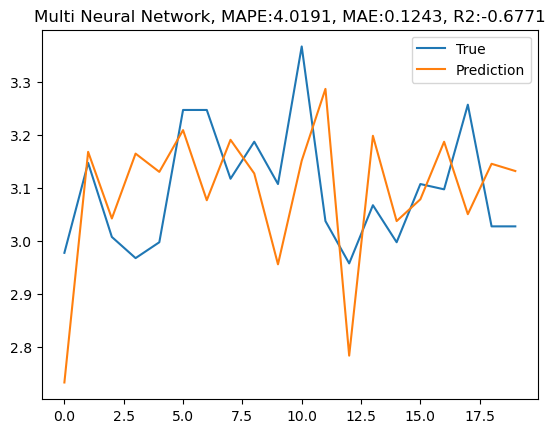

In [ ]:
Multinet.eval()
with torch.inference_mode():
  x, y = next(iter(tst_dl))
  x, y = x.flatten(1).to(device), y[:,:,0].to(device)
  p = Multinet(x)

y = y.cpu()/scaler.scale_[0] + scaler.min_[0]
p = p.cpu()/scaler.scale_[0] + scaler.min_[0]

y = np.concatenate([y[:,0], y[-1,1:]])
p = np.concatenate([p[:,0], p[-1,1:]])

plt.title(f"Multi Neural Network, MAPE:{mape(p,y):.4f}, MAE:{mae(p,y):.4f}, R2:{r2_score(p,y):.4f}")
plt.plot(range(tst_size), y, label="True")
plt.plot(range(tst_size), p, label="Prediction")
plt.legend()
plt.show()

res_dict = {}
res_dict.update({'NN(9*2, 512, 4)': {'MAPE':mape(p,y), 'MAE':mae(p,y),  'R2':r2_score(p,y)}})

In [24]:
torch.save(Multinet.state_dict(), './model/AdamW_multi_(50, 4, 256, 512, 2)model.pth')

In [27]:
# 장기예측
# window_size = 9
window_size = 50
prediction_size = 4
test_size=20
preds = []

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
Multinet.to(device)

# print(type(x), type(y))
x, y = trn_ds[len(trn_ds)-1]
print(x.shape , y.shape)
x = x[:,0]
y = y[:,0]
print(x.shape , y.shape)


for _ in range(test_size):
  y=y.squeeze()

  x = np.concatenate([x,y])[-window_size:]
    
  x_tensor = torch.tensor(x, dtype=torch.float32).to(device)
  y=net(x_tensor)
  y = y.detach().cpu().numpy()
  y= y.reshape(1,prediction_size)
  #print(x,y)
  preds.append(y)



preds = np.concatenate(preds, axis=0)

expanded_preds = np.zeros((preds.shape[0], 3))  
expanded_preds[:, 0] = preds[:, 0]  


inverse_preds = scaler.inverse_transform(expanded_preds)


final_preds = inverse_preds[:, 0]
#print(preds.shape)
#y = y/scaler.scale_[0] + scaler.min_[0]
#preds = preds/scaler.scale_[0] + scaler.min_[0]
#preds = scaler.inverse_transform(preds).squeeze()
#print(preds.shape)
#preds = preds[:,0]
#print(preds.shape)


# 장기예측 plot
df = pd.DataFrame({"ANN_long": final_preds}, index=tst_data.index)
trn, tst = data.Temperature[:-20], data.Temperature[-20:]
ax = tst.plot(label="TRUE")
df.plot(ax=ax)


mape2 = cal_mape(final_preds,data.Temperature[-tst_size:].to_numpy())
print("MAPE: ",mape2)
mae2 = cal_mae(final_preds,data.Temperature[-tst_size:].to_numpy())
print("MAE: ",mae2)
r2_score2 = cal_r2_score(final_preds,data.Temperature[-tst_size:].to_numpy())
print("R2_Score: ", r2_score2)

(50, 2) (4, 2)
(50,) (4,)


ValueError: operands could not be broadcast together with shapes (20,3) (2,) (20,3) 